In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/media/xwan/HDD2/Projects/postNAS


In [3]:
from search_spaces.nas301 import NASBench301

In [4]:
import pickle
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import seaborn as sns
from copy import deepcopy
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
sns.set_style("whitegrid")


In [5]:
from collections import OrderedDict

In [6]:
shorthand = {
    'sep_conv_3x3': 's3',
    'sep_conv_5x5': 's5',
    'dil_conv_3x3': 'd3',
    'dil_conv_5x5': 'd5',
    'skip_connect': 'skip',
    'max_pool_3x3': 'mp3',
    'avg_pool_3x3': 'ap3',
    '': '',
}
shorthand_ = OrderedDict({k : v for k, v in shorthand.items() if k != ''})
OPS = list(shorthand.keys())
OPS = [o for o in OPS if o != '']

In [7]:
cplate = sns.color_palette("Set2", 7)
cplate = cplate.as_hex()
# cplate[4] = cplate[-1]
# cplate = cplate[:-1]
colors = {k: cplate[i] for i, k in enumerate(shorthand_.values())}

In [8]:
data_path = 'data/nb301_top_arch_info_with_importance.pickle'

In [9]:
data = pickle.load(open(data_path, 'rb'))

In [10]:
data[0].keys()

dict_keys(['final_metric_score', 'optimized_hyperparamater_config', 'budget', 'info', 'test_accuracy', 'runtime', 'created_by_optimizer', 'learning_curves', 'genotype', 'edge_graph_normal', 'edge_graph_reduce'])

In [11]:
all_scores = [i['final_metric_score'] for i in data]

In [12]:
ss = NASBench301(file_path='/media/xwan/HDD2/NASDatasets/nasbench301_models_v0.9/nb_models',)

In [13]:
ss.negative=False
ss.log_scale=False

In [14]:
def plot_cell(cell: nx.Graph, grad_norms=None, thres=None):
    plt.figure(figsize=[6, 6])
#     pos = graphviz_layout(cell)
    pos = nx.spring_layout(cell)
    g = cell
    node_color = ['gray'] * len(cell)
    M = cell.number_of_edges()
#     edge_colors = [] * M
    edge_alphas = {(ni, no): 0.1 for ni, no in g.edges()}
    edge_colors = ['gray'] * M
    if grad_norms is not None:
        grad_norm_abs = np.abs(list(grad_norms.values()))
        scaled_graph_norms = {}
        for k, v in grad_norms.items():
            scaled_graph_norms[k] = 0.1 + (np.abs(v) - min(grad_norm_abs)) / (max(grad_norm_abs) -  min(grad_norm_abs)) * 0.9
    else:
        grad_norm_abs =  {(ni, no): 0.1 for ni, no in g.edges()}
        scaled_graph_norms =  {(ni, no): 0.1 for ni, no in g.edges()}
        
    node_labels = {}
    for i, (node, data) in enumerate(cell.nodes(data=True)):
        if 'input' in str(data['node_name']): node_color[i] = 'orange'
        elif 'output' in str(data['node_name']): node_color[i] = 'lightblue'
        node_labels.update({node: data['node_name']})
        
    nodes = nx.draw_networkx_nodes(cell, pos, node_color=node_color)
    if grad_norms is not None:
        for i, (in_node, out_node, props) in enumerate(cell.edges(data=True)):
            
            edge_alphas[(in_node, out_node)] = abs(float(scaled_graph_norms[(in_node, out_node)]))
            if thres is not None and abs(grad_norms[(in_node, out_node)]) < thres: 
                edge_colors[i] = 'gray'
            elif grad_norms[(in_node, out_node)] > 0:  edge_colors[i] = 'green'
            elif grad_norms[(in_node, out_node)] < 0:  edge_colors[i] = 'red'
            else:  edge_colors[i] = 'gray'
            print(in_node, out_node, props['op_name'], grad_norms[(in_node, out_node)], scaled_graph_norms[(in_node, out_node)])
#     edge_alphas = edge_alphas.flatten().astype(np.float)
#     print(edge_alphas)
    edges = nx.draw_networkx_edges(
                cell,
                pos,
                arrowstyle="->",
                arrowsize=10,
                edge_color=edge_colors,
                edge_cmap=plt.cm.Blues,
                width=2,
#                 alpha=edge_alphas,
            )
    edge_labels = []
    #     print(edges)
    for i, (in_node, out_node, props) in enumerate(cell.edges(data=True)):
        edges[i].set_alpha(edge_alphas[(in_node, out_node)])
#             print(i)
    nx.draw_networkx_labels(cell, pos, labels=node_labels)
    edge_labels = nx.get_edge_attributes(cell, 'op_name')
    try:
        edge_labels = {k: shorthand[v] for k, v in edge_labels.items()}
    except:
        edge_labels = {k:v  for k, v in edge_labels.items()}

    nx.draw_networkx_edge_labels(cell, pos=pos, edge_labels=edge_labels)

In [16]:
normal_graphs, reduce_graphs = [], []
for i, it in enumerate(data):
    normal_graphs.append(it['edge_graph_normal'])
    reduce_graphs.append(it['edge_graph_reduce'])

In [17]:
all_graphs = normal_graphs + reduce_graphs

In [18]:
from collections import OrderedDict

In [19]:
# get the weight distribution by operationsa
op_weights_normal = OrderedDict({op: [] for op in OPS})
op_impt_weights_normal = OrderedDict({op: [] for op in OPS})
for i, graph in enumerate(normal_graphs):
    for ni, no, data in graph.edges(data=True):
        op_name = data['op_name']
        op_weights_normal[op_name].append(data['weight'])
        if data['weight'] > 0.001:
            op_impt_weights_normal[op_name].append(data['weight'])

In [20]:
# get the weight distribution by operationsa
op_weights_reduce = {op: [] for op in OPS}
op_impt_weights_reduce = {op: [] for op in OPS}
for i, graph in enumerate(reduce_graphs):
    for ni, no, data in graph.edges(data=True):
        op_name = data['op_name']
        op_weights_reduce[op_name].append(data['weight'])
        if data['weight'] > 0.001:
            op_impt_weights_reduce[op_name].append(data['weight'])

In [21]:
op_weights_reduce_counts = {k: len(v) for k, v in op_weights_reduce.items()}
op_weights_normal_counts = {k: len(v) for k, v in op_weights_normal.items()}

In [22]:
op_weights_reduce_counts_sum = sum(op_weights_reduce_counts.values())
op_weights_normal_counts_sum = sum(op_weights_normal_counts.values())


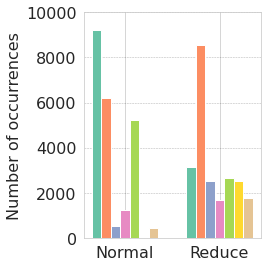

In [24]:
data = np.array([
    list(op_weights_normal_counts.values()),
    list(op_weights_reduce_counts.values()),
    
])
length = len(data)
x_labels = ['Normal', 'Reduce']

# Set plot parameters
fig, ax = plt.subplots(figsize=[4, 4])
width = 0.1 # width of bar
x = np.arange(length)
for i in range(7):
    op = list(shorthand_.values())[i]
    ax.bar(x + (i * width), data[:,i], width, color=colors[op], label=op, )

ax.set_ylabel('Number of occurrences')
# ax.set_ylim(0,75)
ax.set_xticks(x + width * 3)
ax.set_xticklabels(x_labels)
# ax.set_xlabel('Scenario')
# ax.set_title('Title')
# ax.legend(ncol=7)
# ax.set_yscale('log')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
# plt.axhline(np.sum(data, axis=1)[0]/7, color='gray', linestyle='--', linewidth=2)
fig.tight_layout()
# plt.show()
plt.ylim([0, 10000])
plt.savefig('figs/op_distr.pdf', dpi=200, bbox_inches='tight')

In [24]:
op_impt_weights_reduce_counts = {k: len(v) for k, v in op_impt_weights_reduce.items()}
op_impt_weights_normal_counts = {k: len(v) for k, v in op_impt_weights_normal.items()}

(0.0, 10000.0)

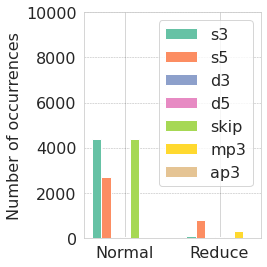

In [25]:
data = np.array([
    list(op_impt_weights_normal_counts.values()),
    list(op_impt_weights_reduce_counts.values()),
    
])
length = len(data)
x_labels = ['Normal', 'Reduce']

# Set plot parameters
fig, ax = plt.subplots(figsize=[4, 4])
width = 0.1 # width of bar
x = np.arange(length)
for i in range(7):
    op = list(shorthand_.values())[i]
    ax.bar(x + (i * width), data[:,i], width, color=colors[op], label=op, )
    
ax.set_ylabel('Number of occurrences')
# ax.set_ylim(0,75)
ax.set_xticks(x + width * 3)
ax.set_xticklabels(x_labels)
# ax.set_yscale('log')
# ax.set_xlabel('Scenario')
# ax.set_title('Title')
ax.legend()
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
# plt.axhline(np.sum(data, axis=1)[0]/7, color='gray', linestyle='--', linewidth=2)
fig.tight_layout()
plt.ylim([0, 10000])
# plt.savefig('figs/impt_op_distr.pdf', dpi=200, bbox_inches='tight')

In [26]:
import pandas as pd

(-0.002, 0.004)


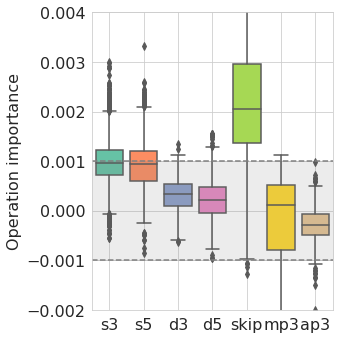

In [36]:
fig, ax = plt.subplots(figsize=[5, 5])
maxsize = max([len(a) for a in op_weights_normal.values()])
op_weights_padded = {k:np.pad(v, pad_width=(0,maxsize-len(v),), mode='constant', constant_values=np.nan) for k,v in op_weights_normal.items()}
df = pd.DataFrame(op_weights_padded)
sns.boxplot(data=df, ax=ax, palette=cplate, saturation=1)
# plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.set_xticklabels(shorthand_.values())
plt.fill_between(np.arange(-0.5, 7.5), -0.001, 0.001, color='gray', alpha=0.15)
plt.axhline(0.001, color='gray', linestyle='--')
plt.axhline(-0.001, color='gray', linestyle='--')
# plt.fill_between(-0.0017, 0.0017, color='gray', alpha=0.1)
plt.ylim([-0.002, 0.004])
plt.grid(True, 'both')
plt.ylabel('Operation importance')
print(plt.ylim())
plt.savefig('figs/normal_impt_weight_good_cells_nb301.pdf', dpi=200, bbox_inches='tight')

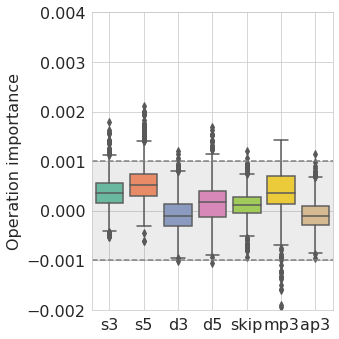

In [35]:
fig, ax = plt.subplots(figsize=[5, 5])
maxsize = max([len(a) for a in op_weights_reduce.values()])
op_weights_padded = {k:np.pad(v, pad_width=(0,maxsize-len(v),), mode='constant', constant_values=np.nan) for k,v in op_weights_reduce.items()}
df = pd.DataFrame(op_weights_padded)
sns.boxplot(data=df, ax=ax, palette=cplate, saturation=1)
# plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.set_xticklabels(shorthand_.values())
plt.fill_between(np.arange(-0.5, 7.5), -0.001, 0.001, color='gray', alpha=0.15)

plt.axhline(0.001, color='gray', linestyle='--')
plt.axhline(-0.001, color='gray', linestyle='--')
plt.ylabel('Operation importance')
plt.grid(True, 'both')
plt.ylim([-0.002, 0.004])
plt.savefig('figs/reduce_impt_weight_good_cells_nb301.pdf', dpi=200, bbox_inches='tight')

In [51]:
data_path = 'data/nb301_bottom_arch_info_with_importance.pickle'
data = pickle.load(open(data_path, 'rb'))
normal_graphs, reduce_graphs = [], []
for i, it in enumerate(data):
    normal_graphs.append(it['edge_graph_normal'])
    reduce_graphs.append(it['edge_graph_reduce'])
all_graphs = normal_graphs + reduce_graphs


In [57]:
# get the weight distribution by operationsa
op_weights_normal = OrderedDict({op: [] for op in OPS})
op_impt_weights_normal = OrderedDict({op: [] for op in OPS})
for i, graph in enumerate(normal_graphs):
    for ni, no, data in graph.edges(data=True):
        op_name = data['op_name']
        op_weights_normal[op_name].append(data['weight'])
        if data['weight'] < -0.001:
            op_impt_weights_normal[op_name].append(data['weight'])

In [58]:
# get the weight distribution by operationsa
op_weights_reduce = {op: [] for op in OPS}
op_impt_weights_reduce = {op: [] for op in OPS}
for i, graph in enumerate(reduce_graphs):
    for ni, no, data in graph.edges(data=True):
        op_name = data['op_name']
        op_weights_reduce[op_name].append(data['weight'])
        if data['weight'] < -0.001:
            op_impt_weights_reduce[op_name].append(data['weight'])

In [59]:
op_weights_reduce_counts = {k: len(v) for k, v in op_weights_reduce.items()}
op_weights_normal_counts = {k: len(v) for k, v in op_weights_normal.items()}

In [60]:
# get the weight distribution by operationsa
op_weights_reduce = {op: [] for op in OPS}
op_impt_weights_reduce = {op: [] for op in OPS}
for i, graph in enumerate(reduce_graphs):
    for ni, no, data in graph.edges(data=True):
        op_name = data['op_name']
        op_weights_reduce[op_name].append(data['weight'])
        if data['weight'] < -0.001:
            op_impt_weights_reduce[op_name].append(data['weight'])

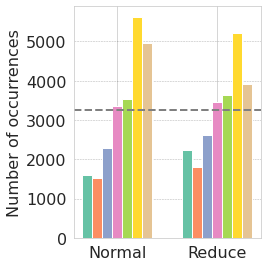

In [61]:
data = np.array([
    list(op_weights_normal_counts.values()),
    list(op_weights_reduce_counts.values()),
    
])
length = len(data)
x_labels = ['Normal', 'Reduce']

# Set plot parameters
fig, ax = plt.subplots(figsize=[4, 4])
width = 0.1 # width of bar
x = np.arange(length)
for i in range(7):
    op = list(shorthand_.values())[i]
    ax.bar(x + (i * width), data[:,i], width, color=colors[op], label=op, )
# ax.bar(x + width, data[:,1], width, color='#0F52BA', label='Case-2', )
# ax.bar(x + (2 * width), data[:,2], width, color='#6593F5', label='Case-3',)
# ax.bar(x + (3 * width), data[:,3], width, color='#73C2FB', label='Case-4',)
# ax.bar(x + (4 * width), data[:,4], width, color='#73C2FB', label='Case-5',)
# ax.bar(x + (5 * width), data[:,5], width, color='#73C2FB', label='Case-6',)
# ax.bar(x + (6 * width), data[:,6], width, color='#73C2FB', label='Case-7',)

ax.set_ylabel('Number of occurrences')
# ax.set_ylim(0,75)
ax.set_xticks(x + width * 3)
ax.set_xticklabels(x_labels)
# ax.set_xlabel('Scenario')
# ax.set_title('Title')
# ax.legend(ncol=7)
# ax.set_yscale('log')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.axhline(np.sum(data, axis=1)[0]/7, color='gray', linestyle='--', linewidth=2)
fig.tight_layout()
# plt.show()
plt.savefig('figs/op_distr_bad.pdf', dpi=200, bbox_inches='tight')

In [62]:
op_impt_weights_reduce_counts = {k: len(v) for k, v in op_impt_weights_reduce.items()}
op_impt_weights_normal_counts = {k: len(v) for k, v in op_impt_weights_normal.items()}

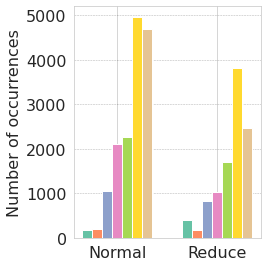

In [64]:
data = np.array([
    list(op_impt_weights_normal_counts.values()),
    list(op_impt_weights_reduce_counts.values()),
    
])
length = len(data)
x_labels = ['Normal', 'Reduce']

# Set plot parameters
fig, ax = plt.subplots(figsize=[4, 4])
width = 0.1 # width of bar
x = np.arange(length)
for i in range(7):
    op = list(shorthand_.values())[i]
    ax.bar(x + (i * width), data[:,i], width, color=colors[op], label=op, )
# ax.bar(x + width, data[:,1], width, color='#0F52BA', label='Case-2', )
# ax.bar(x + (2 * width), data[:,2], width, color='#6593F5', label='Case-3',)
# ax.bar(x + (3 * width), data[:,3], width, color='#73C2FB', label='Case-4',)
# ax.bar(x + (4 * width), data[:,4], width, color='#73C2FB', label='Case-5',)
# ax.bar(x + (5 * width), data[:,5], width, color='#73C2FB', label='Case-6',)
# ax.bar(x + (6 * width), data[:,6], width, color='#73C2FB', label='Case-7',)

ax.set_ylabel('Number of occurrences')
# ax.set_ylim(0,75)
ax.set_xticks(x + width * 3)
ax.set_xticklabels(x_labels)
# ax.set_yscale('log')
# ax.set_xlabel('Scenario')
# ax.set_title('Title')
# ax.legend()
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
# plt.axhline(np.sum(data, axis=1)[0]/7, color='gray', linestyle='--', linewidth=2)
fig.tight_layout()
# plt.show()
plt.savefig('figs/impt_op_distr_bad.pdf', dpi=200, bbox_inches='tight')

In [42]:
raw_data = pickle.load(open('data/nb301_bottom_arch_info_with_importance.pickle', 'rb'))

In [58]:
op_weight_input0_skip = []
op_weight_input1_skip = []
op_weight_both_skip = []
op_weight_other = []
all_weights = []
in0_skip, in1_skip, both_skip, either_skip = 0, 0, 0, 0
for i, data_point in tqdm(enumerate(raw_data)):
    edge_graph_normal = data_point['edge_graph_normal']
    has_input0_skip = False
    has_input1_skip = False
    has_both_skip = False
    has_either_skip = False
    for ei, eo, prop in edge_graph_normal.edges(data=True):
        if prop['op_name'] == 'skip_connect':
            all_weights.append(prop['weight'])
        if ei == 0 and prop['op_name'] == 'skip_connect':
            op_weight_input0_skip.append(prop['weight'])  # skip connect with input 0
            has_input0_skip = True
            has_either_skip = True
        elif ei == 1 and prop['op_name'] == 'skip_connect':
            op_weight_input1_skip.append(prop['weight'])
            has_input1_skip = True
            has_either_skip = True
        elif prop['op_name'] == 'skip_connect':
            op_weight_other.append(prop['weight'])
    if has_input0_skip: in0_skip += 1
    if has_input1_skip: in1_skip += 1
    if has_input0_skip or has_input1_skip: either_skip += 1
    if has_input0_skip and has_input1_skip: both_skip += 1

2859it [00:00, 75310.34it/s]


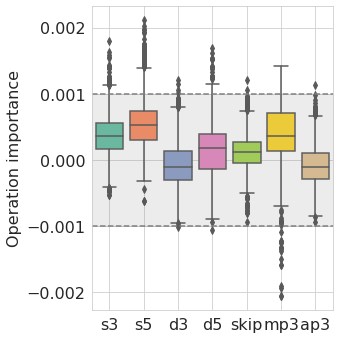

In [53]:
fig, ax = plt.subplots(figsize=[5, 5])
maxsize = max([len(a) for a in op_weights_reduce.values()])
op_weights_padded = {k:np.pad(v, pad_width=(0,maxsize-len(v),), mode='constant', constant_values=np.nan) for k,v in op_weights_reduce.items()}
df = pd.DataFrame(op_weights_padded)
sns.boxplot(data=df, ax=ax, palette=cplate, saturation=1)
# plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.set_xticklabels(shorthand_.values())
plt.fill_between(np.arange(-0.5, 7.5), -0.001, 0.001, color='gray', alpha=0.15)
plt.axhline(0.001, color='gray', linestyle='--')
plt.axhline(-0.001, color='gray', linestyle='--')
# plt.ylim([-0.02, 0.01])
plt.ylabel('Operation importance')
plt.grid(True, 'both')
# plt.savefig('figs/reduce_impt_weight_bad_cells_nb301.pdf', dpi=200, bbox_inches='tight')